In [228]:
import random

from keras.layers import *
from keras.losses import cosine_proximity, categorical_crossentropy, mean_squared_error
from keras.models import Model
from keras import backend as K
from keras.utils import to_categorical
import tensorflow as tf
from acquisition import get_trainset_list, prep_data

In [229]:
# Custom loss layer
class CustomDistanceLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomDistanceLossLayer, self).__init__(**kwargs)

    def distance_loss(self, anchor, positive, negative):
        loss = cosine_proximity(anchor, positive) - cosine_proximity(anchor, negative) # environ 10 max next time increase factor value
        return K.mean(loss, axis=-1) / 10

    def call(self, inputs):
        x = inputs[0]
        positive = inputs[1]
        negative = inputs[2]
        loss = self.distance_loss(x, positive, negative)
        self.add_loss(loss, inputs=inputs)
        return x

In [230]:
# Custom loss layer
class CustomFinalLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomFinalLossLayer, self).__init__(**kwargs)

    def final_loss(self, image, label, image_decoded, label_predicted):
        # environ 15 max
        loss = (K.mean(categorical_crossentropy(label, label_predicted), axis=-1) / 15) \
             + (K.mean(mean_squared_error(image, image_decoded), axis=-1) / 20000) # environ 20000 max
        return loss

    def call(self, inputs):
        image = inputs[0]
        label = inputs[1]
        image_decoded = inputs[2]
        label_predicted = inputs[3]
        loss = self.final_loss(image, label, image_decoded, label_predicted)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return label_predicted

In [231]:
pool_func = MaxPooling2D(pool_size=(2, 2), strides=None, padding="same")

conv_1_func = Conv2D(filters=4, kernel_size=(5, 5), strides=1, padding="same", activation="relu")
conv_2_func = Conv2D(filters=2, kernel_size=(3, 3), strides=1, padding="same", activation="relu")
fully_connected = Dense(2, activation="softmax")

input_layer = Input(shape=(36, 36, 1))
conv_1 = conv_1_func(input_layer)
pool_1 = pool_func(conv_1)
conv_2 = conv_2_func(pool_1)
pool_2 = pool_func(conv_2)
to_be_densed = Flatten()(pool_2)

encoder = Model(input_layer, to_be_densed, name='encoder')

anchor = Input(shape=(36, 36, 1))
positive = Input(shape=(36, 36, 1))
negative = Input(shape=(36, 36, 1))
labels = Input(shape=(2,))

cosine_loss = CustomDistanceLossLayer()([encoder(anchor), encoder(positive), encoder(negative)])

upsample = UpSampling2D()


conv_3_func = Conv2D(filters=2, kernel_size=(3, 3), strides=1, padding="same", activation="relu")
reshaping = Reshape((9, 9, 2))
conv_4_func = Conv2D(filters=2, kernel_size=(3, 3), strides=1, padding="same", activation="relu")
conv_5_func = Conv2D(filters=1, kernel_size=(5, 5), strides=1, padding="same", activation="relu")

input_decoder = Input((162,))
reshaped = reshaping(input_decoder)
conv_3 = conv_3_func(reshaped)
up_1 = upsample(conv_3)
conv_4 = conv_4_func(up_1)
up_2 = upsample(conv_4)
output_decoder = conv_5_func(up_2)

decoder = Model(input_decoder, output_decoder, name='decoder')

autoencoder_output = decoder(cosine_loss)

output_categorical_layer = fully_connected(cosine_loss)

output = CustomFinalLossLayer()([anchor, labels, autoencoder_output, output_categorical_layer])
model = Model([anchor, positive, negative, labels], [output], name='full network')

In [232]:
model.compile('adam', None, ['accuracy'])

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Output "custom_final_loss_layer_18" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_final_loss_layer_18" during training.
  """Entry point for launching an IPython kernel.


In [234]:
positive_images, positive_labels, negative_images, negative_labels = get_trainset_list(15000, 15000)

anchors_positive = positive_images[:5000]
anchors_negative = negative_images[:5000]
anchors = np.concatenate((anchors_positive, anchors_negative), axis=0)

positive_positive = positive_images[5000:10000]
positive_negative = negative_images[5000:10000]
positive_samples = np.concatenate((positive_positive, positive_negative), axis=0)

negative_positive = positive_images[10000:]
negative_negative = negative_images[10000:]
negative_samples = np.concatenate((negative_positive, negative_negative), axis=0)

anchors_labels = np.concatenate((positive_labels[:5000], negative_labels[:5000]))

indices = list(range(len(anchors)))

random.shuffle(indices)

anchors = np.expand_dims(prep_data(anchors[indices]), axis=3)
positive_samples = np.expand_dims(prep_data(positive_samples[indices]), axis=3)
negative_samples = np.expand_dims(prep_data(negative_samples[indices]), axis=3)
anchors_labels = np.asarray(list(map(lambda x: int(x), anchors_labels[indices])))


Processed 0 of 10000
Processed 250 of 10000
Processed 500 of 10000
Processed 750 of 10000
Processed 1000 of 10000
Processed 1250 of 10000
Processed 1500 of 10000
Processed 1750 of 10000
Processed 2000 of 10000
Processed 2250 of 10000
Processed 2500 of 10000
Processed 2750 of 10000
Processed 3000 of 10000
Processed 3250 of 10000
Processed 3500 of 10000
Processed 3750 of 10000
Processed 4000 of 10000
Processed 4250 of 10000
Processed 4500 of 10000
Processed 4750 of 10000
Processed 5000 of 10000
Processed 5250 of 10000
Processed 5500 of 10000
Processed 5750 of 10000
Processed 6000 of 10000
Processed 6250 of 10000
Processed 6500 of 10000
Processed 6750 of 10000
Processed 7000 of 10000
Processed 7250 of 10000
Processed 7500 of 10000
Processed 7750 of 10000
Processed 8000 of 10000
Processed 8250 of 10000
Processed 8500 of 10000
Processed 8750 of 10000
Processed 9000 of 10000
Processed 9250 of 10000
Processed 9500 of 10000
Processed 9750 of 10000
Processed 0 of 10000
Processed 250 of 10000
Pr

In [235]:
model.fit(x=[anchors, positive_samples, negative_samples, to_categorical(anchors_labels)], batch_size=50, epochs=40)

Epoch 1/40
10000/10000 [==============================] - 19s 2ms/step - loss: 0.4881
Epoch 2/40
10000/10000 [==============================] - 18s 2ms/step - loss: 0.1634
Epoch 3/40
10000/10000 [==============================] - 20s 2ms/step - loss: 0.1308
Epoch 4/40
10000/10000 [==============================] - 20s 2ms/step - loss: 0.1089
Epoch 5/40
10000/10000 [==============================] - 21s 2ms/step - loss: 0.0923
Epoch 6/40
10000/10000 [==============================] - 21s 2ms/step - loss: 0.0840
Epoch 7/40
10000/10000 [==============================] - 21s 2ms/step - loss: 0.0774
Epoch 8/40
10000/10000 [==============================] - 22s 2ms/step - loss: 0.0719
Epoch 9/40
10000/10000 [==============================] - 22s 2ms/step - loss: 0.0670
Epoch 10/40
10000/10000 [==============================] - 22s 2ms/step - loss: 0.0634
Epoch 11/40
10000/10000 [==============================] - 22s 2ms/step - loss: 0.0605
Epoch 12/40
10000/10000 [===========================

In [236]:
print(anchors.shape) 
print(positive_samples.shape) 
print(negative_samples.shape)
print(anchors_labels.shape)

(10000, 36, 36, 1)
(10000, 36, 36, 1)
(10000, 36, 36, 1)
(10000,)


In [76]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           (None, 36, 36, 1)    0                                            
__________________________________________________________________________________________________
input_61 (InputLayer)           (None, 36, 36, 1)    0                                            
__________________________________________________________________________________________________
input_62 (InputLayer)           (None, 36, 36, 1)    0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 162)          178         input_60[0][0]                   
                                                                 input_61[0][0]                   
          

In [75]:
print(np.isnan(anchors).any()) 
print(np.isnan(positive_samples).any()) 
print(np.isnan(negative_samples).any())
print(np.isnan(anchors_labels).any())

False
False
False
False


In [227]:
anchors_labels[4]

array([1, 0])

In [147]:
import matplotlib.pyplot as plt

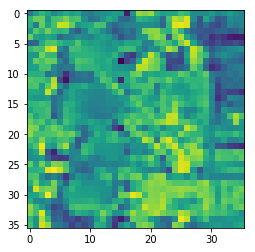

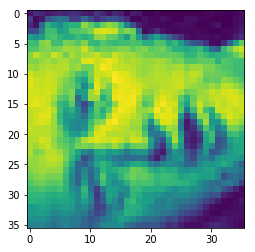

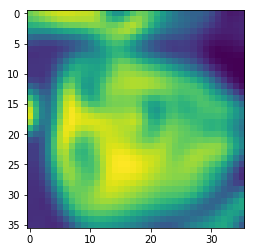

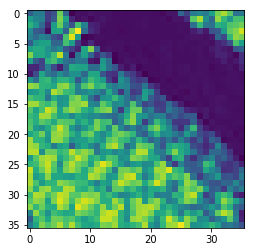

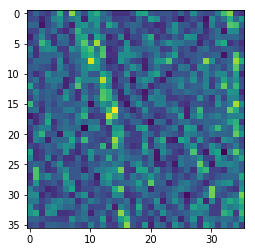

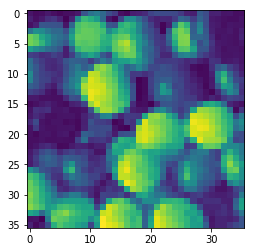

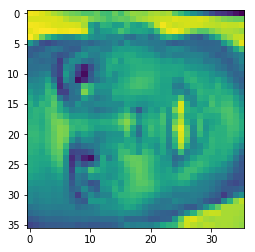

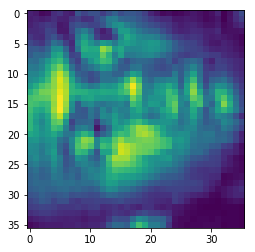

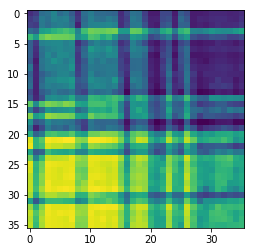

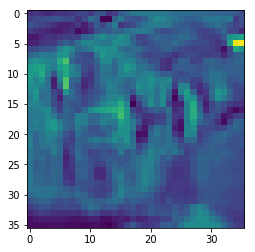

In [238]:
for i in range(10):
    plt.imshow(anchors[i, :, :, 0])
    plt.show()

In [257]:
encoding = encoder.predict(anchors[3:4])

In [258]:
decoded = decoder.predict(encoding)

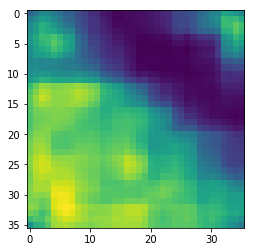

In [259]:
plt.imshow(decoded[0, :, :, 0])
plt.show()

In [260]:
model.predict([anchors[0:10], np.zeros((10, 36, 36, 1)), np.zeros((10, 36, 36, 1)), np.zeros((10,2))])

array([[  9.99998331e-01,   1.62542028e-06],
       [  8.53027089e-08,   9.99999881e-01],
       [  4.25168313e-03,   9.95748341e-01],
       [  9.99446571e-01,   5.53441583e-04],
       [  9.99869943e-01,   1.29985696e-04],
       [  9.40639496e-01,   5.93605414e-02],
       [  7.57064189e-09,   1.00000000e+00],
       [  3.22318166e-01,   6.77681863e-01],
       [  9.99999523e-01,   5.33619414e-07],
       [  5.24767302e-03,   9.94752288e-01]], dtype=float32)

In [270]:
encoding_p1 = encoder.predict(anchors[1:2])
encoding_p2 = encoder.predict(anchors[1:2])
encoding_n1 = encoder.predict(anchors[:10])

In [271]:
from scipy.spatial.distance import cosine

In [272]:
for i in range(10):
    print(cosine(encoding_p1, encoding_n1[i]))

0.160266280174
0.0
0.18865776062
0.255438923836
0.171914160252
0.290135502815
0.197115838528
0.139010250568
0.223371505737
0.126053214073


In [262]:
to_categorical(anchors_labels[:10])

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.]])

In [263]:
input_value = Input(shape=(36, 36, 1))
output_value = fully_connected(encoder(input_value))
model_to_save = Model(input_value, output_value)

In [264]:
model_to_save.predict(anchors[0:10])

array([[  9.99998331e-01,   1.62542028e-06],
       [  8.53027089e-08,   9.99999881e-01],
       [  4.25168313e-03,   9.95748341e-01],
       [  9.99446571e-01,   5.53441583e-04],
       [  9.99869943e-01,   1.29985696e-04],
       [  9.40639496e-01,   5.93605414e-02],
       [  7.57064189e-09,   1.00000000e+00],
       [  3.22318166e-01,   6.77681863e-01],
       [  9.99999523e-01,   5.33619414e-07],
       [  5.24767302e-03,   9.94752288e-01]], dtype=float32)

In [273]:
model_to_save.save('autoencoder_predictor.cnn')

In [274]:
model.save('full_autoencoder.cnn')

In [275]:
encoder.save('encoder.cnn')

In [276]:
decoder.save('decoder.cnn')